# https://github.com/Joeychen80627/Disaster-Tweets-Kaggle-Mini-Project

# Project

## Brief description of the problem and data

This project aims to predict the content on Twitter, allowing for quick classification of words and determining whether a tweet is related to a disaster.

The challenge involves natural language processing (NLP) using LSTM to classify text data.

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [4]:
!pip install fasttext
!pip install tensorflow


In [9]:
import pandas as pd
import re
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Brief description of the data

The training set (train.csv) contains 7,613 data entries with the following columns: id, keyword, location, text, and target (where target is labeled as 0 or 1 to indicate whether the tweet is about a disaster).
The test set (test.csv) contains 3,263 data entries, with the same columns as the training set except for the target column, which is used for model prediction.

In [10]:
train_df=pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [11]:
test_df=pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [12]:
print(train_df.shape)
print(test_df.shape)

(7613, 5)
(3263, 4)


## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data 

Clean the data by removing punctuation, converting text to lowercase, and eliminating unnecessary words such as "is" and "on." The text is cleaned by removing irrelevant characters and stopwords.

Then, sort and display the top 20 most frequent words. However, this processed data will not be used for analysis, as the preprocess_text function may be too aggressive in removing punctuation, which could affect certain meanings and disrupt LSTM's ability to capture contextual connections.

In [13]:
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

train_df_visual=train_df.copy()

train_df_visual['cleaned_text']=train_df_visual['text'].apply(preprocess_text)

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

train_df_visual['cleaned_text']=train_df_visual['cleaned_text'].apply(remove_stopwords)

train_df_visual = train_df_visual[['cleaned_text', 'target']].reset_index(drop=True)

print(train_df_visual.head())

                                        cleaned_text  target
0       deeds reason earthquake may allah forgive us       1
1              forest fire near la ronge sask canada       1
2  residents asked shelter place notified officer...       1
3  people receive wildfires evacuation orders cal...       1
4  got sent photo ruby alaska smoke wildfires pou...       1


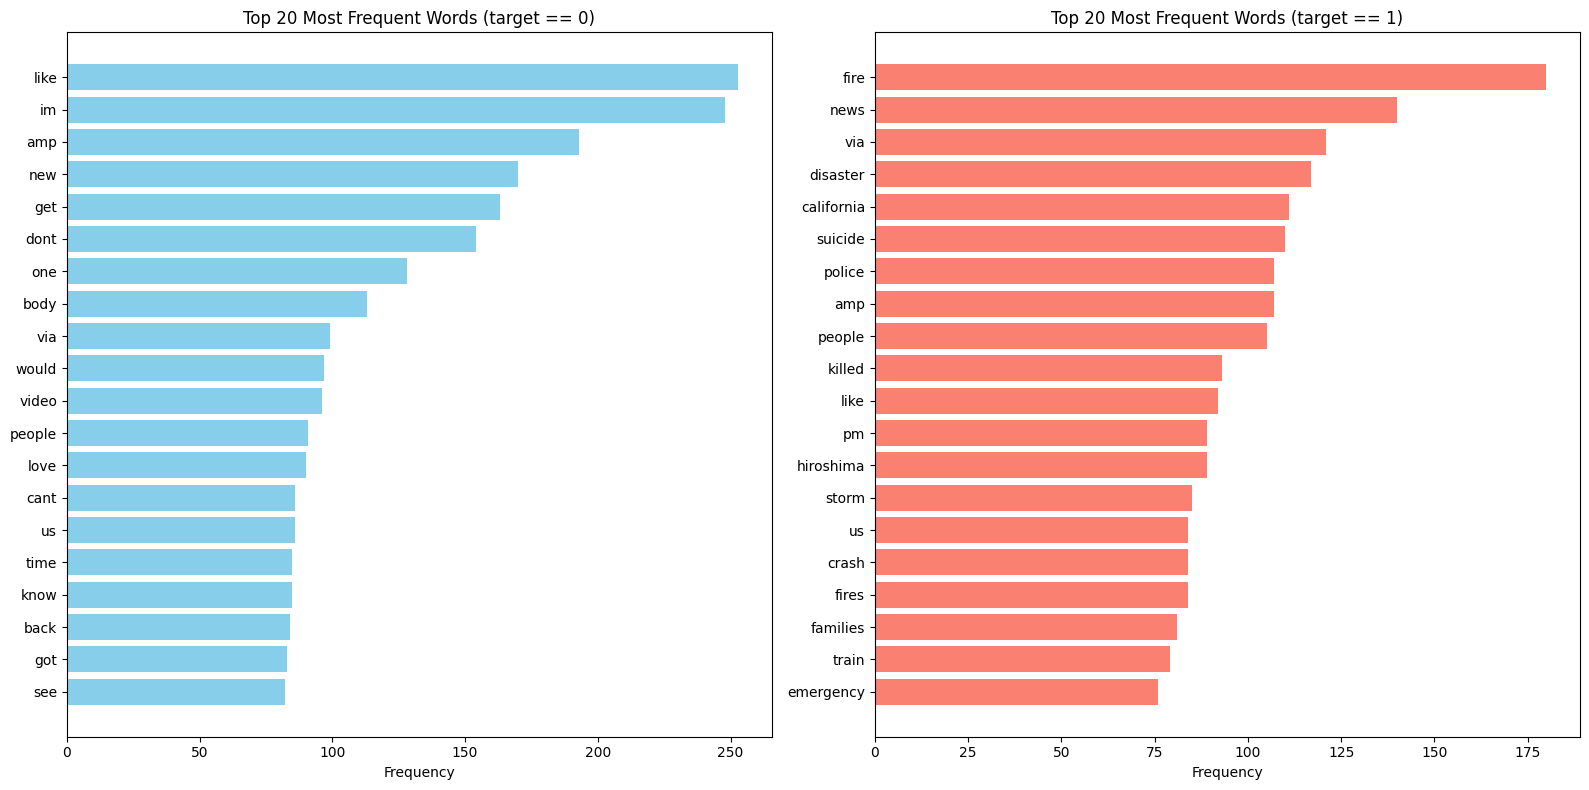

In [14]:
from collections import Counter
import matplotlib.pyplot as plt


train_target_0 = train_df_visual[train_df_visual['target'] == 0]
train_target_1 = train_df_visual[train_df_visual['target'] == 1]


all_words_0 = ' '.join(train_target_0['cleaned_text']).split()
word_freq_0 = Counter(all_words_0)
common_words_0 = word_freq_0.most_common(20)
words_0, frequencies_0 = zip(*common_words_0)


all_words_1 = ' '.join(train_target_1['cleaned_text']).split()
word_freq_1 = Counter(all_words_1)
common_words_1 = word_freq_1.most_common(20)
words_1, frequencies_1 = zip(*common_words_1)


fig, axes = plt.subplots(1, 2, figsize=(16, 8))


axes[0].barh(words_0, frequencies_0, color='skyblue')
axes[0].set_xlabel('Frequency')
axes[0].set_title('Top 20 Most Frequent Words (target == 0)')
axes[0].invert_yaxis()  

# target == 1 
axes[1].barh(words_1, frequencies_1, color='salmon')
axes[1].set_xlabel('Frequency')
axes[1].set_title('Top 20 Most Frequent Words (target == 1)')
axes[1].invert_yaxis()  


plt.tight_layout()
plt.show()


## Model Architecture



In [15]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
!gunzip cc.en.300.vec.gz

--2025-04-02 07:43:31--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.164.78.81, 18.164.78.121, 18.164.78.72, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.164.78.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G   332MB/s    in 4.0s    

2025-04-02 07:43:35 (314 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]



In [16]:
import gensim
from gensim.models import KeyedVectors


word2vec_path = "cc.en.300.vec"  
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_path, binary=False)


In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 10000  
max_len = 100  

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_df['text'])  

X_train_seq = tokenizer.texts_to_sequences(train_df['text'])
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)

word_index = tokenizer.word_index  
print(f"word index size：{len(word_index)}")


word index size：22700


In [18]:
import numpy as np

embedding_dim = 300  # Word2Vec 是 300 維
embedding_matrix = np.zeros((max_words, embedding_dim))  # 初始化矩陣

for word, i in word_index.items():
    if i < max_words:
        if word in word2vec_model:  # 如果詞在 Word2Vec 中有對應向量
            embedding_matrix[i] = word2vec_model[word]  # 存入矩陣

print(f"build {embedding_matrix.shape[0]} x {embedding_matrix.shape[1]} 's word vector matrix")


build 10000 x 300 's word vector matrix


In [20]:
from keras.layers import Input, LSTM, Embedding, Dense, Dropout, Bidirectional
from keras.optimizers import Adam
from keras.metrics import AUC  

model = Sequential([
    Embedding(input_dim=max_words, output_dim=300,  # 改成 300
              weights=[embedding_matrix], trainable=False),  
    Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)),  
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  
])

model.compile(optimizer=Adam(learning_rate=0.001),  
              loss='binary_crossentropy',
              metrics=['accuracy', AUC(name='auc')])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,000,000 (11.44 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,000,000 (11.44 MB)

In [22]:
y = train_df['target'].values  

In [23]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)


history = model.fit(
    X_train_pad,
    y,
    epochs=50,    
    batch_size=32, 
    validation_split=0.2,  
    callbacks=[early_stopping]
)

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.6527 - auc: 0.6753 - loss: 0.6260 - val_accuracy: 0.7242 - val_auc: 0.8018 - val_loss: 0.5532
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - accuracy: 0.7758 - auc: 0.8208 - loss: 0.5007 - val_accuracy: 0.7978 - val_auc: 0.8637 - val_loss: 0.4450
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.8057 - auc: 0.8555 - loss: 0.4532 - val_accuracy: 0.8011 - val_auc: 0.8681 - val_loss: 0.4632
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - accuracy: 0.8187 - auc: 0.8647 - loss: 0.4322 - val_accuracy: 0.8076 - val_auc: 0.8705 - val_loss: 0.4329
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 18s 93ms/step - accuracy: 0.8142 - auc: 0.8578 - loss: 0.4421 - val_accuracy: 0.8056 - val_auc: 0.8712 - val_loss: 0.4380
Epoch 6/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.8167 - auc: 0.8710 - loss: 0.4275 - val_accuracy: 0.8043 - val_auc: 0.8705 - val_loss: 0.4401
Epoch 7/50
191/191 ━━━━━━━━

In [25]:
test_target = test_df['id']
test_text = test_df['text']

In [26]:
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

test_text_seq = tokenizer.texts_to_sequences(test_df['text'])
test_text_pad = pad_sequences(test_text_seq, maxlen=max_len)

results = model.predict(test_text_pad)
results = results.reshape(-1)  # 確保為一維
results = (results > 0.5).astype(int)  # 轉換為 0 或 1

assert len(test_df['id']) == len(results), "Error: test_ids and results length mismatch!"

submission = pd.DataFrame({
    'id': test_df['id'],
    'target': results
})


# 輸出 CSV
submission.to_csv("submission.csv", index=False)
print("✅ Submission file saved!")

102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step
✅ Submission file saved!


In [27]:
def graph_train_hist(history):
    # Plot loss curves
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label="Train Loss")
    plt.plot(history.history['val_loss'], label="Validation Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label="Train Accuracy")
    plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

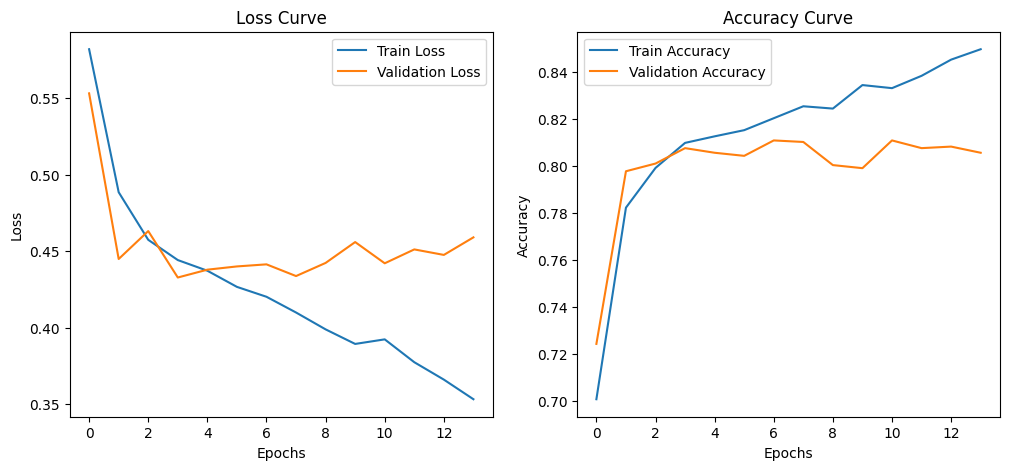

In [28]:
graph_train_hist(history)